# Demo: How to Use pyGLMHMM

Here, we want to show the application of pyGLMHMM on some simulated data.

## Importing the required dependencies

We start importing the required dependencies for generating the simulated data and running the main program:

In [51]:
%load_ext autoreload
%autoreload 2

import numpy as np
import scipy.stats
import scipy.ndimage.filters
import matplotlib.pyplot as plt
from pyGLMHMM.GLMHMM import GLMHMMEstimator

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Setting the initial parameters of GLMHMMEstimator for num_sample = 1

An instance of 'GLMHMMEstimator' class must be generated with its different parameters. The most important ones are:

- num_samples: the number of distinct samples in the input data
- num_states: the number of hidden internal states
- num_emissions: the number of emitted behaviors or actions (like song types)
- num_feedbacks: the number of sensory feedback cues
- num_filter_bins: the number of bins to discretize the filters of sensory feedback cues
- num_steps: the number of steps taken in the maximization step of the EM algorithm for calculating the emission matrix
- filter_offset: the number of bias terms added to the sensory feedback cues

In [52]:
num_samples = 1
num_states = 2
num_emissions = 2
num_feedbacks = 3
num_filter_bins = 30
num_steps = 1
filter_offset = 1

## Initializing the simulation variables

In [53]:
tau = 4
total_time = 10000
noiseSD = 0.1
stim_scale = 1
num_real_states = 2

In [54]:
stim = []
states = []
output_stim = []
output_symb = []

## Generating random stimuli (sensory feedback cues)

In [55]:
stim_temp = np.zeros((num_filter_bins, total_time + num_filter_bins - 1, num_feedbacks))
stim_temp[0, :, :] = scipy.ndimage.filters.gaussian_filter(np.random.randn(total_time + num_filter_bins - 1, num_feedbacks), stim_scale)
    
for i in range(1, num_filter_bins):
    stim_temp[i, 0:total_time, :] = stim_temp[0, i:(total_time + i), :]
    
stim.append(stim_temp[:, 0:total_time, :] + np.random.randn(num_filter_bins, total_time, num_feedbacks) * noiseSD)

We concatenate the stimuli of all sensory feedback cues and augment it with bias or offset terms (with value '1') and generate the final 'output_stim' (X) variable: 

In [56]:
final_stim = np.append(stim[0][:, :, 0], stim[0][:, :, 1], axis = 0)
final_stim = np.append(final_stim, stim[0][:, :, 2], axis = 0)
final_stim = np.append(final_stim, np.ones((filter_offset, total_time)), axis = 0)
output_stim.append(final_stim)

## Generating a random filter which acts on behavior emissions and state transitions

The GLM–HMM model allows each state to have an associated multinomial GLM or 'filter' to describe the mapping from feedback cues to the probability of emitting a particular type of behavior. Each state also has a multinomial GLM or 'filter' that produces a mapping from feedback cues to the transition probabilities from the current state to the next state. 

In [57]:
filt = scipy.stats.gamma.pdf(np.linspace(0, num_filter_bins), a = tau)[0:num_filter_bins]

The filter with positive (nagative) sign acts on the first (second) stimulus type or sensory feedback cue to determine the emission probability of the first type of behavior. Moreover, the filter with nagative (positive) sign acts on the first (second) stimulus type or sensory feedback cue to determine the emission probability of the second type of behavior. Also, the filter with positive sign acts on the third stimulus or sensory feedback cue to determine the transition probability from the first state to the second state.

In [58]:
output = np.zeros((num_real_states, total_time))

p1 = np.exp(np.matmul(stim[0][:, :, 0].T, filt.T) + np.matmul(stim[0][:, :, 1].T, -filt.T))
output[0, :] = p1 / (1 + p1) > 0.5
p2 = np.exp(np.matmul(stim[0][:, :, 0].T, -filt.T) + np.matmul(stim[0][:, :, 1].T, filt.T))
output[1, :] = p2 / (1 + p2) > 0.5

p3 = np.exp(np.matmul(stim[0][:, :, 2].T, filt.T))
states.append(p3 / (1 + p3) > 0.5)

We generate the final 'output_symb' (y) variable: 

In [59]:
output_symb.append(np.zeros(total_time))
for ss in range(0, num_real_states):
    output_symb[0][states[0] == ss] = output[ss][states[0] == ss]

Here are the plots for emission and transtion filters across sensory feedback cues:

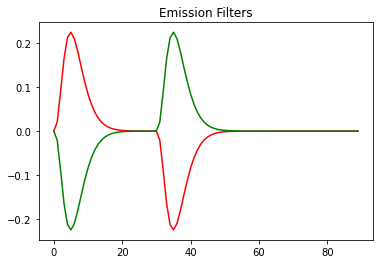

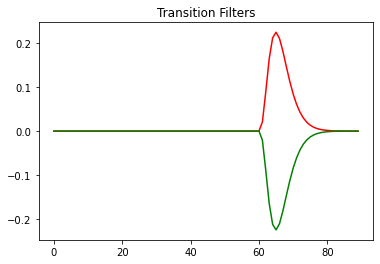

In [60]:
emission1 = np.expand_dims(np.concatenate((filt, -filt, np.zeros(num_filter_bins)), axis = 0), axis = 1)
emission2 = np.expand_dims(np.concatenate((-filt, filt, np.zeros(num_filter_bins)), axis = 0), axis = 1)
emission_filter = np.concatenate((emission1, emission2), axis = 1).T

plt.figure()
plt.title("Emission Filters")
plt.plot(range(0, 90), emission_filter[0, :], "-r")
plt.plot(range(0, 90), emission_filter[1, :], "-g")
plt.show()

transition1 = np.expand_dims(np.concatenate((np.zeros(num_filter_bins), np.zeros(num_filter_bins), filt), axis = 0), axis = 1)
transition2 = np.expand_dims(np.concatenate((np.zeros(num_filter_bins), np.zeros(num_filter_bins), -filt), axis = 0), axis = 1)
transition_filter = np.concatenate((transition1, transition2), axis = 1).T

plt.figure()
plt.title("Transition Filters")
plt.plot(range(0, 90), transition_filter[0, :], "-r")
plt.plot(range(0, 90), transition_filter[1, :], "-g")
plt.show()

## Running the GLM-HMM fitting

Now, we generate an instance of 'GLMHMMEstimator' class with the initial parameters and run the 'fit' method with the simulated variables, 'output_stim' and 'output_symb'. Be cautious that running of the 'fit' method may take few hours:

In [94]:
output_symb[0].shape

(10000,)

In [61]:
estimator = GLMHMMEstimator(
                            num_samples = num_samples, 
                            num_states = num_states, 
                            num_emissions = num_emissions, 
                            num_feedbacks = num_feedbacks, 
                            num_filter_bins = num_filter_bins, 
                            num_steps = num_steps, 
                            filter_offset = filter_offset)
output = estimator.fit(output_stim, output_symb, [])

+++++++++++++++++++++
Fitting iteration:   1
+++++++++++++++++++++
Fitting categorical emission filters
---- State 0 ----


/Users/andrewsong/1_Research/workspace/pyGLMHMM/src/pyglmhmm/src/pyGLMHMM/emitLearningFun.py:7: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "_emit_learning_fun" failed type inference due to: Untyped global name 'spdiags': Cannot determine Numba type of <class 'function'>

File "../src/pyGLMHMM/emitLearningFun.py", line 81:
def _emit_learning_fun(emit_w, stim, state_num, options):
    <source elided>
        else:
            grad_regularization = grad_regularization + options['smooth_lambda'] * (np.matmul(D, emit_w.T)).T
            ^

  @jit
/Users/andrewsong/1_Research/workspace/pyGLMHMM/src/pyglmhmm/src/pyGLMHMM/emitLearningFun.py:7: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplifting enabled because Function "_emit_learning_fun" failed type inference due to: Cannot determine Numba type of <class 'numba.core.dispatcher.LiftedLoop'>

File "../src/pyGLMHMM/emitLearningFun.py", line 25:
def _emit_learning

==================================== Summary ======================================
Iterations: 33
Function Evaluations: 38
F: 0.3148801624774933
||g||: 2.299723018950317e-05
---- State 1 ----
==================================== Summary ======================================
Iterations: 32
Function Evaluations: 34
F: 0.2505829930305481
||g||: 5.3856016165809706e-05
Fitting state transition filters
==================================== Summary ======================================
Iterations: 34
Function Evaluations: 40
F: 0.2500942349433899
||g||: 2.4657829271745868e-05
==================================== Summary ======================================
Iterations: 30
Function Evaluations: 35
F: 0.1783803403377533
||g||: 4.512766463449225e-05
Log likelihood: 9939.788426759265
+++++++++++++++++++++
Fitting iteration:   2
+++++++++++++++++++++
Fitting categorical emission filters
---- State 0 ----
==================================== Summary ======================================
Iterati

==================================== Summary ======================================
Iterations: 29
Function Evaluations: 33
F: 0.12642285227775574
||g||: 8.176972187357023e-06
Log likelihood: 5526.33769854158
+++++++++++++++++++++
Fitting iteration:   8
+++++++++++++++++++++
Fitting categorical emission filters
---- State 0 ----
==================================== Summary ======================================
Iterations: 33
Function Evaluations: 36
F: 0.2095189243555069
||g||: 7.396501132461708e-06
---- State 1 ----
==================================== Summary ======================================
Iterations: 40
Function Evaluations: 46
F: 0.025573112070560455
||g||: 2.4659177142893896e-05
Fitting state transition filters
==================================== Summary ======================================
Iterations: 33
Function Evaluations: 37
F: 0.0687992200255394
||g||: 8.167711712303571e-06
==================================== Summary ======================================
Iterat

==================================== Summary ======================================
Iterations: 40
Function Evaluations: 153
F: 0.007091036066412926
||g||: 9.782508277567104e-05
Fitting state transition filters
==================================== Summary ======================================
Iterations: 40
Function Evaluations: 153
F: 0.004232754465192556
||g||: 0.0002967667824123055
==================================== Summary ======================================
Iterations: 40
Function Evaluations: 151
F: 0.004094518721103668
||g||: 0.00030780473025515676
Log likelihood: 232.85372266379574
+++++++++++++++++++++
Fitting iteration:   15
+++++++++++++++++++++
Fitting categorical emission filters
---- State 0 ----
==================================== Summary ======================================
Iterations: 40
Function Evaluations: 143
F: 0.007267307490110397
||g||: 0.00013724023301620036
---- State 1 ----
==================================== Summary ================================

/Users/andrewsong/1_Research/workspace/pyGLMHMM/src/pyglmhmm/src/pyGLMHMM/transLearningStats.py:43: RuntimeWarning: overflow encountered in multiply
  hess[i, i, :] = np.sum(np.tile(np.reshape(stim[trial]['gamma'][state_num, 0:-1] * (norm * np.exp(filtpower[set_order[i], :]) - np.exp(2 * filtpower[set_order[i], :])) / np.power(norm, 2), (1, 1, T), order = 'F'), (1, num_bins, 1)) * data_vec, axis = 2)
/Users/andrewsong/1_Research/workspace/pyGLMHMM/src/pyglmhmm/src/pyGLMHMM/transLearningStats.py:43: RuntimeWarning: overflow encountered in exp
  hess[i, i, :] = np.sum(np.tile(np.reshape(stim[trial]['gamma'][state_num, 0:-1] * (norm * np.exp(filtpower[set_order[i], :]) - np.exp(2 * filtpower[set_order[i], :])) / np.power(norm, 2), (1, 1, T), order = 'F'), (1, num_bins, 1)) * data_vec, axis = 2)
/Users/andrewsong/1_Research/workspace/pyGLMHMM/src/pyglmhmm/src/pyGLMHMM/transLearningStats.py:43: RuntimeWarning: invalid value encountered in subtract
  hess[i, i, :] = np.sum(np.tile(np.reshape

Log likelihood: 159.13574329317683
+++++++++++++++++++++
Fitting iteration:   21
+++++++++++++++++++++
Fitting categorical emission filters
---- State 0 ----
==================================== Summary ======================================
Iterations: 40
Function Evaluations: 169
F: 0.005664397031068802
||g||: 0.00018554860434960574
---- State 1 ----
==================================== Summary ======================================
Iterations: 40
Function Evaluations: 162
F: 0.005423105321824551
||g||: 5.925694858888164e-05
Fitting state transition filters
==================================== Summary ======================================
Iterations: 40
Function Evaluations: 191
F: 0.002077757613733411
||g||: 0.0001209153633681126
==================================== Summary ======================================
Iterations: 40
Function Evaluations: 199
F: 0.0022889687679708004
||g||: 3.49446308973711e-05
Log likelihood: 154.54229282137797
+++++++++++++++++++++
Fitting iteration:   

==================================== Summary ======================================
Iterations: 40
Function Evaluations: 203
F: 0.0012092188699170947
||g||: 1.8047148842015304e-05
==================================== Summary ======================================
Iterations: 40
Function Evaluations: 206
F: 0.0016859491588547826
||g||: 2.9978742531966418e-05
Log likelihood: 122.65025940562677
+++++++++++++++++++++
Fitting iteration:   28
+++++++++++++++++++++
Fitting categorical emission filters
---- State 0 ----
==================================== Summary ======================================
Iterations: 40
Function Evaluations: 173
F: 0.004432807210832834
||g||: 3.858047057292424e-05
---- State 1 ----
==================================== Summary ======================================
Iterations: 40
Function Evaluations: 185
F: 0.004339511506259441
||g||: 4.370669194031507e-05
Fitting state transition filters
==================================== Summary ==============================

==================================== Summary ======================================
Iterations: 40
Function Evaluations: 176
F: 0.004122768063098192
||g||: 3.6292007280280814e-05
---- State 1 ----
==================================== Summary ======================================
Iterations: 40
Function Evaluations: 170
F: 0.003946009092032909
||g||: 4.6655368350911885e-05
Fitting state transition filters
==================================== Summary ======================================
Iterations: 5
Function Evaluations: 29
F: 0.0010682096472010016
||g||: 1.5215163330140058e-05
==================================== Summary ======================================
Iterations: 11
Function Evaluations: 64
F: 0.0013741886941716075
||g||: 1.959686414920725e-05
Log likelihood: 105.11177675321898
+++++++++++++++++++++
Fitting iteration:   35
+++++++++++++++++++++
Fitting categorical emission filters
---- State 0 ----
==================================== Summary ================================

==================================== Summary ======================================
Iterations: 1
Function Evaluations: 10
F: 0.001261032884940505
||g||: 1.640822119952645e-05
Log likelihood: 94.11367620555902
+++++++++++++++++++++
Fitting iteration:   41
+++++++++++++++++++++
Fitting categorical emission filters
---- State 0 ----
==================================== Summary ======================================
Iterations: 40
Function Evaluations: 184
F: 0.0037501624319702387
||g||: 8.398754289373755e-05
---- State 1 ----
==================================== Summary ======================================
Iterations: 40
Function Evaluations: 187
F: 0.003230046248063445
||g||: 8.603329479228705e-05
Fitting state transition filters
==================================== Summary ======================================
Iterations: 29
Function Evaluations: 156
F: 0.0010138323996216059
||g||: 1.4341951100504957e-05
==================================== Summary ==================================

==================================== Summary ======================================
Iterations: 40
Function Evaluations: 183
F: 0.002948976121842861
||g||: 2.609827606647741e-05
Fitting state transition filters
==================================== Summary ======================================
Iterations: 4
Function Evaluations: 23
F: 0.0010037511819973588
||g||: 1.6506166502949782e-05
==================================== Summary ======================================
Iterations: 1
Function Evaluations: 7
F: 0.0012263634707778692
||g||: 1.646074088057503e-05
Log likelihood: 82.65490553505792
+++++++++++++++++++++
Fitting iteration:   48
+++++++++++++++++++++
Fitting categorical emission filters
---- State 0 ----
==================================== Summary ======================================
Iterations: 18
Function Evaluations: 94
F: 0.003060656599700451
||g||: 5.113726365379989e-05
---- State 1 ----
==================================== Summary ======================================

Log likelihood: 78.00066699647785
+++++++++++++++++++++
Fitting iteration:   54
+++++++++++++++++++++
Fitting categorical emission filters
---- State 0 ----
==================================== Summary ======================================
Iterations: 2
Function Evaluations: 12
F: 0.0029967587906867266
||g||: 2.272118035762105e-05
---- State 1 ----
==================================== Summary ======================================
Iterations: 21
Function Evaluations: 102
F: 0.0027092539239674807
||g||: 4.3806794565171e-05
Fitting state transition filters
==================================== Summary ======================================
Iterations: 8
Function Evaluations: 45
F: 0.0009822348365560174
||g||: 1.4249986634240486e-05
==================================== Summary ======================================
Iterations: 1
Function Evaluations: 7
F: 0.0010880278423428535
||g||: 1.5334506315412e-05
Log likelihood: 77.7627809778017
+++++++++++++++++++++
Fitting iteration:   55
+++++++

==================================== Summary ======================================
Iterations: 6
Function Evaluations: 33
F: 0.0009265966946259141
||g||: 1.4649050172010902e-05
==================================== Summary ======================================
Iterations: 2
Function Evaluations: 14
F: 0.0010776093695312738
||g||: 1.589081875863485e-05
Log likelihood: 76.60915592492114
+++++++++++++++++++++
Fitting iteration:   61
+++++++++++++++++++++
Fitting categorical emission filters
---- State 0 ----
==================================== Summary ======================================
Iterations: 3
Function Evaluations: 16
F: 0.0029584302101284266
||g||: 2.263668466184754e-05
---- State 1 ----
==================================== Summary ======================================
Iterations: 39
Function Evaluations: 192
F: 0.0026424145326018333
||g||: 2.3069234885042533e-05
Fitting state transition filters
==================================== Summary ===================================

==================================== Summary ======================================
Iterations: 36
Function Evaluations: 180
F: 0.002777645830065012
||g||: 1.9649438399937935e-05
---- State 1 ----
==================================== Summary ======================================
Iterations: 39
Function Evaluations: 175
F: 0.002411140128970146
||g||: 1.9779185095103458e-05
Fitting state transition filters
==================================== Summary ======================================
Iterations: 9
Function Evaluations: 57
F: 0.0008617116836830974
||g||: 1.3243915418570396e-05
==================================== Summary ======================================
Iterations: 1
Function Evaluations: 7
F: 0.0010669758776202798
||g||: 1.37968700073543e-05
Log likelihood: 71.17476104511563
+++++++++++++++++++++
Fitting iteration:   68
+++++++++++++++++++++
Fitting categorical emission filters
---- State 0 ----
==================================== Summary ====================================

==================================== Summary ======================================
Iterations: 4
Function Evaluations: 24
F: 0.0010596191277727485
||g||: 1.310653351538349e-05
Log likelihood: 70.54612127692386
+++++++++++++++++++++
Fitting iteration:   74
+++++++++++++++++++++
Fitting categorical emission filters
---- State 0 ----
==================================== Summary ======================================
Iterations: 1
Function Evaluations: 8
F: 0.002734650392085314
||g||: 1.9742414224310778e-05
---- State 1 ----
==================================== Summary ======================================
Iterations: 1
Function Evaluations: 10
F: 0.002410154789686203
||g||: 1.9704206351889297e-05
Fitting state transition filters
==================================== Summary ======================================
Iterations: 1
Function Evaluations: 7
F: 0.0008487990708090365
||g||: 1.310913467023056e-05
==================================== Summary ======================================
It

Fitting state transition filters
==================================== Summary ======================================
Iterations: 4
Function Evaluations: 24
F: 0.000846226466819644
||g||: 1.2693844837485813e-05
==================================== Summary ======================================
Iterations: 1
Function Evaluations: 7
F: 0.001057319575920701
||g||: 1.3358203432289883e-05
Log likelihood: 70.32327048438506
+++++++++++++++++++++
Fitting iteration:   81
+++++++++++++++++++++
Fitting categorical emission filters
---- State 0 ----
==================================== Summary ======================================
Iterations: 10
Function Evaluations: 56
F: 0.0027139808516949415
||g||: 2.050433431577403e-05
---- State 1 ----
==================================== Summary ======================================
Iterations: 11
Function Evaluations: 52
F: 0.002394079463556409
||g||: 1.984814844036009e-05
Fitting state transition filters
==================================== Summary ======

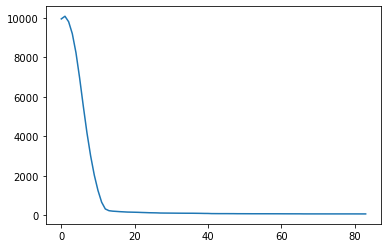

In [62]:
plt.plot(output[-1]['loglik'])

## The initial emission and transtion matrices

Because the total probability is one, we can arbitrarily set one set of filters for one emitted bahavior or state to zero. So in our example, we would have an emission matrix with the size of ((num_states) * (num_emissions - 1) * (num_feedbacks * num_filter_bins + 1)) = (2, 1, 91) and a transition matrix with the size of (num_states * num_states * (num_feedbacks * num_filter_bins + 1)) = (2, 2, 91) in which the diagonal elements would be ignored. Here are the plots for initial emission and transition matrices which must be compared with the filters plots:

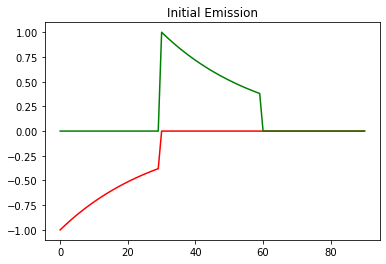

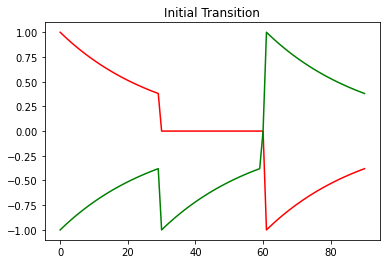

In [63]:
plt.figure()
plt.title("Initial Emission")
plt.plot(range(0, 91), estimator.emit_w_init_[0, 0, :], "-r")
plt.plot(range(0, 91), estimator.emit_w_init_[1, 0, :], "-g")
plt.show()

plt.figure()
plt.title("Initial Transition")
plt.plot(range(0, 91), estimator.trans_w_init_[0, 1, :], "-r")
plt.plot(range(0, 91), estimator.trans_w_init_[1, 0, :], "-g")
plt.show()

## The final emission and transtion matrices

The output is a dictionary which has many useful varaiables generated through consecutive iterations of the EM algorithm of the 'fit' method. Here, we plot the final emission and transition matrices which must be compared with the initial ones and also with filters plots:

In [89]:
a=-np.inf*np.ones(10)

In [90]:
b=np.random.randn(10)

In [92]:
0.5*np.inf + 3*np.inf

inf

In [91]:
print(a)
print(b)
print(np.dot(a,b))

[-inf -inf -inf -inf -inf -inf -inf -inf -inf -inf]
[ 1.9792346  -1.65478423  0.24305175  1.42924477  1.01658899  0.61883389
  0.00453138 -0.92775766 -0.20770455 -0.89495955]
nan


In [64]:
emit_w_final = output[-1]['emit_w']
trans_w_final = output[-1]['trans_w']

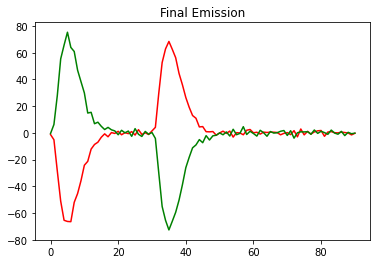

In [65]:
plt.figure()
plt.title("Final Emission")
plt.plot(range(0, 91), emit_w_final[0, 0, :], "-r")
plt.plot(range(0, 91), emit_w_final[1, 0, :], "-g")
plt.show()

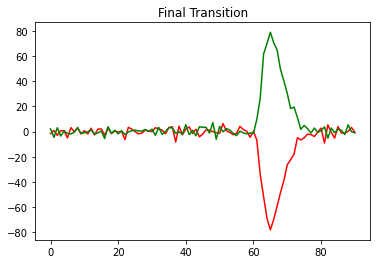

In [66]:
plt.figure()
plt.title("Final Transition")
plt.plot(range(0, 91), trans_w_final[0, 1, :], "-r")
plt.plot(range(0, 91), trans_w_final[1, 0, :], "-g")
plt.show()

## Another similar example with num_sample = 5

In [43]:
num_samples = 5
num_states = 2
num_emissions = 2
num_feedbacks = 3
num_filter_bins = 30
num_steps = 1
filter_offset = 1
    
tau = 4
total_time = 10000
noiseSD = 0.1
stim_scale = 1
num_real_states = 2
    
stim = []
states = []
output_stim = []
output_symb = []
    
for ns in range(0, num_samples):
    output = np.zeros((num_real_states, total_time))
    
    stim_temp = np.zeros((num_filter_bins, total_time + num_filter_bins - 1, num_feedbacks))
    stim_temp[0, :, :] = scipy.ndimage.filters.gaussian_filter(np.random.randn(total_time + num_filter_bins - 1, num_feedbacks), stim_scale)
    
    for i in range(1, num_filter_bins):
        stim_temp[i, 0:total_time, :] = stim_temp[0, i:(total_time + i), :]
        
    stim.append(stim_temp[:, 0:total_time, :] + np.random.randn(num_filter_bins, total_time, num_feedbacks) * noiseSD)
        
    final_stim = np.append(stim[ns][:, :, 0], stim[ns][:, :, 1], axis = 0)
    final_stim = np.append(final_stim, stim[ns][:, :, 2], axis = 0)
    final_stim = np.append(final_stim, np.ones((filter_offset, total_time)), axis = 0)
    output_stim.append(final_stim)
        
    filt = scipy.stats.gamma.pdf(np.linspace(0, num_filter_bins), a = tau)[0:num_filter_bins]
    
    p1 = np.exp(np.matmul(stim[ns][:, :, 0].T, filt.T) + np.matmul(stim[ns][:, :, 1].T, -filt.T))
    output[0, :] = p1 / (1 + p1) > 0.5
    p2 = np.exp(np.matmul(stim[ns][:, :, 0].T, -filt.T) + np.matmul(stim[ns][:, :, 1].T, filt.T))
    output[1, :] = p2 / (1 + p2) > 0.5
    
    p3 = np.exp(np.matmul(stim[ns][:, :, 2].T, filt.T))
    states.append(p3 / (1 + p3) > 0.5)
    
    output_symb.append(np.zeros(total_time))
    for ss in range(0, num_real_states):
        output_symb[ns][states[ns] == ss] = output[ss][states[ns] == ss]
    
estimator = GLMHMMEstimator(num_samples = num_samples, num_states = num_states, num_emissions = num_emissions, num_feedbacks = num_feedbacks, num_filter_bins = num_filter_bins, num_steps = num_steps, filter_offset = filter_offset)
output = estimator.fit(output_stim, output_symb, [])

+++++++++++++++++++++
Fitting iteration:   1
+++++++++++++++++++++
Fitting categorical emission filters
==================================== Summary ======================================
Iterations: 30
Function Evaluations: 43
F: 0.31013819575309753
||g||: 3.1335697713075206e-05
==================================== Summary ======================================
Iterations: 32
Function Evaluations: 35
F: 0.27919846773147583
||g||: 2.281784691149369e-05
Fitting state transition filters
==================================== Summary ======================================
Iterations: 25
Function Evaluations: 28
F: 0.33933454751968384
||g||: 3.5164979635737836e-05
==================================== Summary ======================================
Iterations: 25
Function Evaluations: 29
F: 0.22095023095607758
||g||: 1.5045387954160105e-05
Log likelihood: 57484.15696328037
+++++++++++++++++++++
Fitting iteration:   2
+++++++++++++++++++++
Fitting categorical emission filters
==================

Log likelihood: 31209.825006833467
+++++++++++++++++++++
Fitting iteration:   8
+++++++++++++++++++++
Fitting categorical emission filters
==================================== Summary ======================================
Iterations: 23
Function Evaluations: 25
F: 0.1647721230983734
||g||: 8.873173101164866e-06
==================================== Summary ======================================
Iterations: 26
Function Evaluations: 29
F: 0.052141595631837845
||g||: 8.38093001220841e-06
Fitting state transition filters
==================================== Summary ======================================
Iterations: 31
Function Evaluations: 36
F: 0.13392744958400726
||g||: 7.329058917093789e-06
==================================== Summary ======================================
Iterations: 30
Function Evaluations: 35
F: 0.1799767017364502
||g||: 5.67109054827597e-06
Log likelihood: 26541.158866625956
+++++++++++++++++++++
Fitting iteration:   9
+++++++++++++++++++++
Fitting categorical emiss

/Users/andrewsong/1_Research/workspace/pyGLMHMM/src/pyglmhmm/src/pyGLMHMM/emitLearningStats.py:35: RuntimeWarning: overflow encountered in exp
  hess_t = (np.exp(2 * filtpower) - np.exp(filtpower) * norm) / np.power(norm, 2)
/Users/andrewsong/1_Research/workspace/pyGLMHMM/src/pyglmhmm/src/pyGLMHMM/emitLearningStats.py:35: RuntimeWarning: overflow encountered in multiply
  hess_t = (np.exp(2 * filtpower) - np.exp(filtpower) * norm) / np.power(norm, 2)
/Users/andrewsong/1_Research/workspace/pyGLMHMM/src/pyglmhmm/src/pyGLMHMM/emitLearningStats.py:35: RuntimeWarning: invalid value encountered in subtract
  hess_t = (np.exp(2 * filtpower) - np.exp(filtpower) * norm) / np.power(norm, 2)
/Users/andrewsong/1_Research/workspace/pyGLMHMM/src/pyglmhmm/src/pyGLMHMM/emitLearningStats.py:35: RuntimeWarning: overflow encountered in power
  hess_t = (np.exp(2 * filtpower) - np.exp(filtpower) * norm) / np.power(norm, 2)


Fitting state transition filters
==================================== Summary ======================================
Iterations: 309
Function Evaluations: 1315
F: 0.005873086396604776
||g||: 3.095881766057573e-05
==================================== Summary ======================================
Iterations: 344
Function Evaluations: 1456
F: 0.006784718483686447
||g||: 3.465021291049197e-05
Log likelihood: 1017.6326741770414
+++++++++++++++++++++
Fitting iteration:   15
+++++++++++++++++++++
Fitting categorical emission filters
==================================== Summary ======================================
Iterations: 287
Function Evaluations: 1383
F: 0.002902054460719228
||g||: 1.912089646793902e-05
==================================== Summary ======================================
Iterations: 50
Function Evaluations: 255
F: 0.002765238517895341
||g||: 2.429915730317589e-05
Fitting state transition filters
==================================== Summary ===============================

==================================== Summary ======================================
Iterations: 32
Function Evaluations: 164
F: 0.0025406302884221077
||g||: 1.959702422027476e-05
Fitting state transition filters
==================================== Summary ======================================
Iterations: 44
Function Evaluations: 226
F: 0.005299948621541262
||g||: 2.767647492873948e-05
==================================== Summary ======================================
Iterations: 1
Function Evaluations: 8
F: 0.005390014965087175
||g||: 2.77740564342821e-05
Log likelihood: 798.5109187698321
+++++++++++++++++++++
Fitting iteration:   22
+++++++++++++++++++++
Fitting categorical emission filters
==================================== Summary ======================================
Iterations: 4
Function Evaluations: 27
F: 0.0027363975532352924
||g||: 1.9599037841544487e-05
==================================== Summary ======================================
Iterations: 1
Function Evaluations:

Fitting categorical emission filters
==================================== Summary ======================================
Iterations: 1
Function Evaluations: 7
F: 0.0024046890903264284
||g||: 1.8401420675218105e-05
==================================== Summary ======================================
Iterations: 1
Function Evaluations: 9
F: 0.0025365001056343317
||g||: 1.9088387489318848e-05
Fitting state transition filters
==================================== Summary ======================================
Iterations: 1
Function Evaluations: 10
F: 0.005256370175629854
||g||: 2.7768770451075397e-05
==================================== Summary ======================================
Iterations: 1
Function Evaluations: 8
F: 0.005278920754790306
||g||: 2.75205875368556e-05
Log likelihood: 773.8240121063798
+++++++++++++++++++++
Fitting iteration:   29
+++++++++++++++++++++
Fitting categorical emission filters
==================================== Summary ======================================
It

Log likelihood: 758.9826813355264
+++++++++++++++++++++
Fitting iteration:   35
+++++++++++++++++++++
Fitting categorical emission filters
==================================== Summary ======================================
Iterations: 1
Function Evaluations: 7
F: 0.0023654066026210785
||g||: 2.3036005586618558e-05
==================================== Summary ======================================
Iterations: 11
Function Evaluations: 60
F: 0.0023606896866112947
||g||: 1.698834057606291e-05
Fitting state transition filters
==================================== Summary ======================================
Iterations: 1
Function Evaluations: 8
F: 0.0052260905504226685
||g||: 2.7510921427165158e-05
==================================== Summary ======================================
Iterations: 1
Function Evaluations: 7
F: 0.005221570376306772
||g||: 2.6530566174187697e-05
Log likelihood: 758.6878476217453
+++++++++++++++++++++
Fitting iteration:   36
+++++++++++++++++++++
Fitting categorica

==================================== Summary ======================================
Iterations: 1
Function Evaluations: 7
F: 0.005080826114863157
||g||: 2.5188644940499216e-05
Log likelihood: 750.1826058516097
+++++++++++++++++++++
Fitting iteration:   42
+++++++++++++++++++++
Fitting categorical emission filters
==================================== Summary ======================================
Iterations: 8
Function Evaluations: 44
F: 0.00203476520255208
||g||: 2.6628176783560775e-05
==================================== Summary ======================================
Iterations: 1
Function Evaluations: 7
F: 0.002356213051825762
||g||: 1.670261008257512e-05
Fitting state transition filters
==================================== Summary ======================================
Iterations: 3
Function Evaluations: 21
F: 0.005203621927648783
||g||: 2.7623165806289762e-05
==================================== Summary ======================================
Iterations: 12
Function Evaluations: 66


Fitting state transition filters
==================================== Summary ======================================
Iterations: 4
Function Evaluations: 24
F: 0.005193790886551142
||g||: 2.7790480089606717e-05
==================================== Summary ======================================
Iterations: 10
Function Evaluations: 53
F: 0.005037504248321056
||g||: 2.6868096028920263e-05
Log likelihood: 727.6200167626101
+++++++++++++++++++++
Fitting iteration:   49
+++++++++++++++++++++
Fitting categorical emission filters
==================================== Summary ======================================
Iterations: 1
Function Evaluations: 7
F: 0.002017074031755328
||g||: 1.815582436393015e-05
==================================== Summary ======================================
Iterations: 13
Function Evaluations: 70
F: 0.002294048434123397
||g||: 2.3698201403021812e-05
Fitting state transition filters
==================================== Summary ======================================
Ite

==================================== Summary ======================================
Iterations: 2
Function Evaluations: 12
F: 0.0022900227922946215
||g||: 1.6616204447927885e-05
Fitting state transition filters
==================================== Summary ======================================
Iterations: 1
Function Evaluations: 8
F: 0.00518411211669445
||g||: 2.738794864853844e-05
==================================== Summary ======================================
Iterations: 10
Function Evaluations: 51
F: 0.004929761867970228
||g||: 2.5114608433796093e-05
Log likelihood: 721.0080645436049
+++++++++++++++++++++
Fitting iteration:   56
+++++++++++++++++++++
Fitting categorical emission filters
==================================== Summary ======================================
Iterations: 1
Function Evaluations: 7
F: 0.002016102895140648
||g||: 1.8165617802878842e-05
==================================== Summary ======================================
Iterations: 4
Function Evaluations: 22

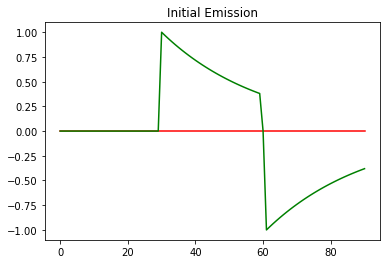

In [44]:
plt.figure()
plt.title("Initial Emission")
plt.plot(range(0, 91), estimator.emit_w_init_[0, 0, :], "-r")
plt.plot(range(0, 91), estimator.emit_w_init_[1, 0, :], "-g")
plt.show()

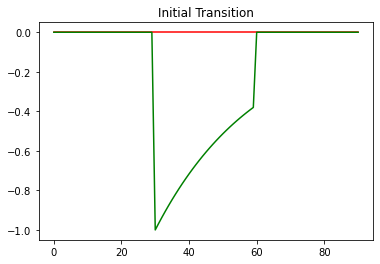

In [45]:
plt.figure()
plt.title("Initial Transition")
plt.plot(range(0, 91), estimator.trans_w_init_[0, 1, :], "-r")
plt.plot(range(0, 91), estimator.trans_w_init_[1, 0, :], "-g")
plt.show()

In [46]:
emit_w_final = output[-1]['emit_w']
trans_w_final = output[-1]['trans_w']

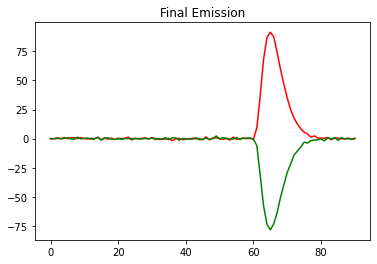

In [47]:
plt.figure()
plt.title("Final Emission")
plt.plot(range(0, 91), emit_w_final[0, 0, :], "-r")
plt.plot(range(0, 91), emit_w_final[1, 0, :], "-g")
plt.show()

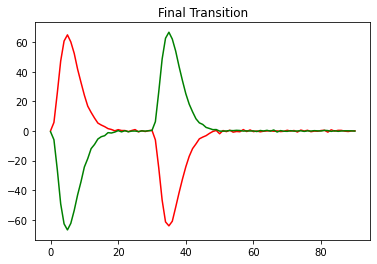

In [48]:
plt.figure()
plt.title("Final Transition")
plt.plot(range(0, 91), trans_w_final[0, 1, :], "-r")
plt.plot(range(0, 91), trans_w_final[1, 0, :], "-g")
plt.show()

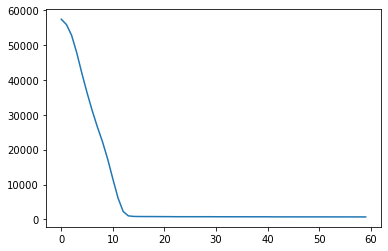

In [50]:
plt.plot(output[-1]['loglik'])